In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from heapq import heappop, heappush
from random import randint
from datetime import datetime
%matplotlib inline

In [2]:
# rectangle (n x m), n >= m > 0
def simple_intersect_cells(n, m):
    cells = []
    
    for i in range(0, n):
        y = i * m // n
        x = i
        cells.append((x, y))
        if x > 0:
            cells.append((x - 1, y))
        if y > 0 and y * n == i * m and y >= 0:
            cells.append((x, y - 1))
            if x > 0:
                cells.append((x - 1, y - 1))
    return cells
    

In [3]:
def intersect_cells(i1, j1, i2, j2):
    cells = []
    start = (i1, j1)
    
    s1 = 1
    l1 = 0
    if i1 > i2:
        s1 = -1
        l1 = -1
        i1, i2 = i2, i1
    
    s2 = 1
    l2 = 0
    if j1 > j2:
        s2 = -1
        l2 = -1
        j1, j2 = j2, j1
    
    r = 0
    if j2 - j1 > i2 - i1:
        r = 1
        i1, i2, j1, j2 = j1, j2, i1, i2
        s1, s2 = s2, s1
        l1, l2 = l2, l1
    
    n = i2 - i1
    m = j2 - j1
    s_cells = simple_intersect_cells(n, m)
    for cell in s_cells:
        if r == 1:
            cells.append((start[0] + cell[1] * s2 + l2, start[1] + cell[0] * s1 + l1))
        else:
            cells.append((start[0] + cell[0] * s1 + l1, start[1] + cell[1] * s2 + l2))
    return cells
    
    

In [4]:
def draw_intersect(width, height, i1, j1, i2, j2):
    '''
    Auxiliary function that visualizes the environment, the path and 
    the open/expanded/re-expanded nodes.
    
    The function assumes that nodes_opened/nodes_expanded/nodes_reexpanded
    are iterable collestions of SearchNodes
    '''
    k = 50
    r = 0.05 * k
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color = 'white')
    draw = ImageDraw.Draw(im)
    
    
    cells = intersect_cells(i1, j1, i2, j2)
    
    for cell in cells:
        i = cell[0]
        j = cell[1]
        draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=(231, 76, 60))
        
    # grid points
    for i in range(height + 1):
        for j in range(width + 1):
            draw.ellipse((j * k - r, i * k - r, j * k + r, i * k + r), fill=(50, 50, 50))
            
    draw.line((j1 * k, i1*k, j2 * k, i2 * k),  fill=( 70, 80, 80 ))
        

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

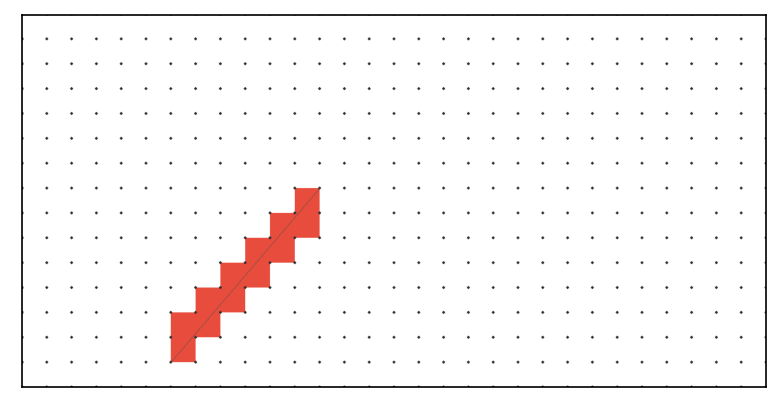

In [5]:
draw_intersect(30, 15, 14, 6, 7, 12)

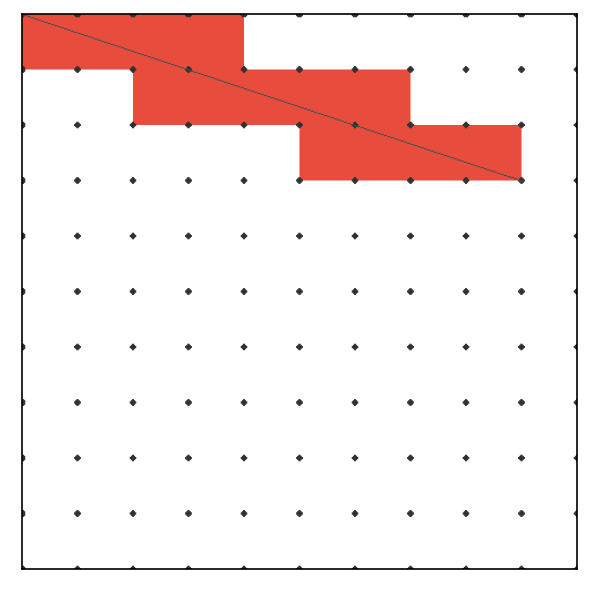

In [6]:
draw_intersect(10, 10, 0, 0, 3, 9)

In [7]:
class Map:

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
    

    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '@' and 'T' representing obstacles and '.' representing free cells) to a grid
        '''
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '@' or c == 'T':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.
        '''
        self._width = width
        self._height = height
        self._cells = grid_cells

    def cell_in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)

    def point_in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j <= self._width) and (0 <= i <= self._height)
    

    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return self.cell_in_bounds(i, j) and (not self._cells[i][j])
    
    def cells_by_delta(self, di, dj):
        if di == 1 and dj == 0:
            return [[0, 0], [0, -1]]
        if di == -1 and dj == 0:
            return [[-1, 0], [-1, -1]]
        if di == 0 and dj == 1:
            return [[0, 0], [-1, 0]]
        if di == 0 and dj == -1:
            return [[0, -1], [-1, -1]]


    def get_neighbors(self, i, j, k = 8):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        It's assumed that grid is 8-connected and we can't cut angles
        '''   
        neighbors = []
        if k == 4:
            delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]
        if k == 8:
            delta = [[0, 1], [1, 0], [0, -1], [-1, 0], [1, 1], [-1, -1], [1, -1], [-1, 1]]
        if k == 16:
            delta = [[0, 1], [1, 0], [0, -1], [-1, 0],
                     [1, 1], [-1, -1], [1, -1], [-1, 1],
                     [1, 2], [-1, -2], [1, -2], [-1, 2],
                     [2, 1], [-2, -1], [2, -1], [-2, 1]]


        for d in delta:
            if self.point_in_bounds(i + d[0], j + d[1]):
                if self.visible(i, j, i + d[0], j + d[1]):
                    neighbors.append((i + d[0], j + d[1]))

        return neighbors
    
    def visible_axes(self, i1, j1, i2, j2):
        if i1 == i2:
            if j1 > j2:
                j1, j2 = j2, j1
            for j in range(j1, j2):
                if not (self.traversable(i1, j) or self.traversable(i1 - 1, j)):
                    return False
            return True
        if j1 == j2:
            if i1 > i2:
                i1, i2 = i2, i1
            for i in range(i1, i2):
                if not (self.traversable(i, j1) or self.traversable(i, j1 - 1)):
                    return False
            return True
        return False # this call not allowed
    
    def visible(self, i1, j1, i2, j2):
        if (i1 == i2) or (j1 == j2):
            return self.visible_axes(i1, j1, i2, j2)
        
        cells = intersect_cells(i1, j1, i2, j2)
        for cell in cells:
            if not self.traversable(cell[0], cell[1]):
#                print("invisible : (", i1, ",", j1, ") and (", i2, ",", j2, ")")
                return False
#        print("  visible : (", i1, ",", j1, ") and (", i2, ",", j2, ")")
        return True

    def get_size(self):
        return (self._height, self._width)


In [8]:
def compute_cost(i1, j1, i2, j2):
    '''
    Computes cost of simple moves between cells
    '''
    return sqrt(abs(i1 - i2) ** 2 + abs(j1 - j2) ** 2)


In [9]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node

    '''

    def __init__(self, i, j, g = 0, h = 0, f = None, parent = None, lazy_parent = None, true_node = False):
        self.i = i
        self.j = j
        self.parent = parent
        self.lazy_parent = lazy_parent
        self.true_node = true_node
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f  
    
    # recount true g-value using a parent
    # recount true f-value using true g-value as well        
    def recount_g(self, grid_map):
        if self.parent is None:
            return
        
        if grid_map.visible(self.i, self.j, self.lazy_parent.i, self.lazy_parent.j):
            self.parent = self.lazy_parent
        
        self.g = self.parent.g + compute_cost(self.i, self.j, self.parent.i, self.parent.j)
        self.true_node = True
        self.f = self.g + self.h
            
    def apply_heuristic(self, heuristic_func, goal_i, goal_j, w):
        self.h = heuristic_func(self, goal_i, goal_j) * w
        self.f = self.g + self.h

    
    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        return (self.i == other.i) and (self.j == other.j) # TODO I also want to compare parents 
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        ij = self.i, self.j
        return hash(ij)
    
    # this function defines order of taking nodes from OPEN
    def priority(self):
        return self.f, -self.g

    def __lt__(self, other):
        return (self.i, self.j) < (other.i, other.j)
    
    def __le__(self, other):
        return (self.i, self.j) <= (other.i, other.j)
    
    def __gt__(self, other):
        return (self.i, self.j) > (other.i, other.j)
    
    def __ge__(self, other):
        return (self.i, self.j) >= (other.i, other.j)
    
    def __eq__(self, other):
        return (self.i, self.j) == (other.i, other.j)
    
    def __ne__(self, other):
        return (self.i, self.j) != (other.i, other.j)
    

In [10]:
class SearchTreePQS: #SearchTree which uses PriorityQueue for OPEN and set for CLOSED
    
    def __init__(self):
        self._open = [] # priority queue (node.priority, node)
        self._closed = set()
        
    def __len__(self):
        return len(self._open) + len(self._closed)
    
    '''
    open_is_empty should inform whether the OPEN is exhausted or not.
    In the former case the search main loop should be interrupted.
    '''
    def open_is_empty(self):
        return len(self._open) == 0
    
    '''
    Adding a node to the search-tree (i.e. to OPEN).
    It's may be a duplicate, and it will be checked in 
    'get_best_node_from_open' method
    '''    
    def add_to_open(self, item):
        heappush(self._open, (item.priority(), item))
    
    
    '''
    Extracting the best node (i.e. the one with the minimal key 
    = min f-value = min g-value (for Dijkstra)) from OPEN.
    This node will be expanded further on in the main loop of the search.
    Can't return a duplicate.
    return Null if open consist of ONLY closed nodes.
    ''' 
    def get_best_node_from_open(self):
        while not self.open_is_empty():
            bestf, best = heappop(self._open)
            if not (self.was_expanded(best)):
                return best
        return None

    def add_to_closed(self, item):
        self._closed.add(item)

    def was_expanded(self, item):
        return item in self._closed

    @property
    def OPEN(self):
        return [item[1] for item in self._open]
    
    @property
    def CLOSED(self):
        return self._closed


In [11]:
class SearchTreePQS_SDD: #SearchTree which uses PriorityQueue for OPEN and set for CLOSED with semi-detection duplicates
    
    def __init__(self):
        self._open = [] # priority queue (node.priority, node)
        self._closed = set()
        self._best = dict()
        
    def __len__(self):
        return len(self._open) + len(self._closed) + len(self._best)
    
    '''
    open_is_empty should inform whether the OPEN is exhausted or not.
    In the former case the search main loop should be interrupted.
    '''
    def open_is_empty(self):
        return len(self._open) == 0
    
    '''
    Adding a node to the search-tree (i.e. to OPEN).
    It's may be a duplicate, and it will be checked in 
    'get_best_node_from_open' method
    '''    
    def add_to_open(self, item):
        if (self._best.get(item) is None) or (self._best.get(item) > item.g):
            heappush(self._open, (item.priority(), item))
            self._best[item] = item.g
    
    
    '''
    Extracting the best node (i.e. the one with the minimal key 
    = min f-value = min g-value (for Dijkstra)) from OPEN.
    This node will be expanded further on in the main loop of the search.
    Can't return a duplicate.
    return Null if open consist of ONLY closed nodes.
    ''' 
    def get_best_node_from_open(self):
        while not self.open_is_empty():
            bestf, best = heappop(self._open)
            if not (self.was_expanded(best)):
                return best
        return None

    def add_to_closed(self, item):
        self._closed.add(item)
        self._best[item] = -1 # we can't add it to open anymore

    def was_expanded(self, item):
        return item in self._closed

    @property
    def OPEN(self):
        return [item[1] for item in self._open]
    
    @property
    def CLOSED(self):
        return self._closed


In [12]:
class SearchTreePQSReexp: #SearchTree with reexpansion which uses PriorityQueue for OPEN and set for CLOSED
    
    def __init__(self):
        self._open = [] # priority queue (node.priority, node)
        self._closed = set()
        self._best = dict()
        
    def __len__(self):
        return len(self._open) + len(self._closed) + len(self._best)
    
    '''
    open_is_empty should inform whether the OPEN is exhausted or not.
    In the former case the search main loop should be interrupted.
    '''
    def open_is_empty(self):
        return len(self._open) == 0
    
    '''
    Adding a node to the search-tree (i.e. to OPEN) if f-value was decreased
    It's may be a duplicate, it is norm for this type of tree
    '''    
    def add_to_open(self, item):
        if (self._best.get(item) is None) or (self._best.get(item) > item.g):
            heappush(self._open, (item.priority(), item))
            if item.true_node:
                self._best[item] = item.g
        self._closed.discard(item) # trying to remove without any exceptions
    
    
    '''
    Extracting the best node (i.e. the one with the minimal key 
    = min f-value = min g-value (for Dijkstra)) from OPEN.
    This node will be expanded further on in the main loop of the search.
    Can take an duplicate.
    return None if and only if open is empty.
    ''' 
    def get_best_node_from_open(self):
        if not self.open_is_empty():
            bestf, best = heappop(self._open)
            return best
        return None

    def add_to_closed(self, item):
        self._closed.add(item)

    def was_expanded(self, item):
        return item in self._closed

    @property
    def OPEN(self):
        return [item[1] for item in self._open]
    
    @property
    def CLOSED(self):
        return self._closed


In [13]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent != current:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [14]:
def getSuccessor(node, i, j, grid_map, goal_i, goal_j, heuristic_func, w):
    suc = Node(i, j, g = node.parent.g + compute_cost(node.parent.i, node.parent.j, i, j),
                    parent = node, lazy_parent = node.parent, true_node = False)
    suc.apply_heuristic(heuristic_func, goal_i, goal_j, w)
    return suc

In [15]:
def getSuccessors(node, grid_map, goal_i, goal_j, heuristic_func, w, k):
#    print("expand node:", node.i, ",", node.j, "with parent:", node.parent.i, ",", node.parent.j)
    neighbors = grid_map.get_neighbors(node.i, node.j, k)
    successors = []
    for cell in neighbors:
        successors.append(getSuccessor(node, cell[0], cell[1], grid_map, goal_i, goal_j, heuristic_func, w))
    return successors

### Visualization

In [16]:
def draw(grid_map, start = None, goal = None, path = None,
         nodes_opened = None, nodes_expanded = None, nodes_reexpanded = None):
    '''
    Auxiliary function that visualizes the environment, the path and 
    the open/expanded/re-expanded nodes.
    
    The function assumes that nodes_opened/nodes_expanded/nodes_reexpanded
    are iterable collestions of SearchNodes
    '''
    k = 15
    r = 0.3 * k
    height, width = grid_map.get_size()
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color = 'white')
    draw = ImageDraw.Draw(im)
    
    # grid points
    for i in range(height + 1):
        for j in range(width + 1):
            pass
#            draw.ellipse((j * k - r, i * k - r, j * k + r, i * k + r), fill=(50, 50, 50))
    
    # obstacles
    for i in range(height):
        for j in range(width):
            if(not grid_map.traversable(i, j)):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    # opened
    if nodes_opened is not None:
        for node in nodes_opened:
            pass
#            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)
    
    # expanded
    if nodes_expanded is not None:
        for node in nodes_expanded:
            pass
#            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(131, 145, 146), width=0)
    
    # reexpanded
    if nodes_reexpanded is not None:
        for node in nodes_reexpanded:
            pass
#                draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(255, 145, 146), width=0)
    
    # path
    if path is not None:
        for step in path:
            draw.line(((step.j * k, step.i * k), (step.parent.j * k, step.parent.i * k)), fill=(219, 152, 52))
            draw.ellipse((step.j * k - r, step.i * k - r, step.j * k + r, step.i * k + r), fill=(52, 152, 219))
                

    if (start is not None) and (grid_map.traversable(start.i, start.j)):
        draw.ellipse((start.j * k - r, start.i * k - r, start.j * k + r, start.i * k + r), fill=(40, 180, 99))
    
    if (goal is not None) and (grid_map.traversable(goal.i, goal.j)):
        draw.ellipse((goal.j * k - r, goal.i * k - r, goal.j * k + r, goal.i * k + r), fill=(231, 76, 60))


    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()


Example of the visualization

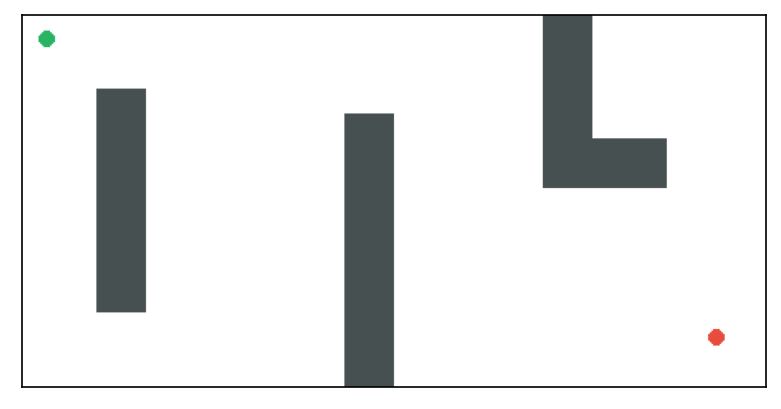

In [17]:

height = 15
width = 30
map_str = '''
.....................@@.......
.....................@@.......
.....................@@.......
...@@................@@.......
...@@........@@......@@.......
...@@........@@......@@@@@....
...@@........@@......@@@@@....
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
.............@@...............
.............@@...............
.............@@...............
'''

test_map = Map()
test_map.read_from_string(map_str, width, height)
start = Node(1, 1)
goal = Node(13, 28)
draw(test_map, start, goal)

In [18]:
def simple_test(search_func, task, *args, **kwargs):
    '''
    simple_test runs search_func on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task
    '''
    
    height = 15
    width = 30
    map_str = '''
.....................@@.......
.....................@@.......
.....................@@.......
...@@................@@.......
...@@........@@......@@.......
...@@........@@......@@@@@....
...@@........@@......@@@@@....
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
.............@@...............
.............@@...............
.............@@...............
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4), (7, 1), (9, 2), (3, 5)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29), (4, 26), (3, 17), (9, 2)]

    if (task is None) or not (0 <= task < len(starts)):
        task = randint(0, len(starts) - 1)
        
    print("task number: ", task)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    try:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args, **kwargs)
        number_of_steps = result[2].expansions
        nodes_created = result[2].max_tree_size
        if result[0]:
            path = make_path(result[1])
            print("Path found! Length: " + str(path[1]) + \
                ". Memory_usage: " + str(nodes_created) + \
                ". Number of steps: " + str(number_of_steps))
            path_cells = [(node.i, node.j) for node in path[0]]
            print(path_cells)
            draw(task_map, start, goal, path[0], *result[3:])
        else:
            print("Path not found!")
        return result

    except Exception as e:
        print("Execution error")
        print(e)


In [19]:
def euclidian_distance(node, goal_i, goal_j):
    
    return sqrt((node.i - goal_i)**2 + (node.j - goal_j)**2)


In [20]:
def theta_heuristic(node, goal_i, goal_j):
    return max(0, node.parent.g + compute_cost(node.parent.i, node.parent.j, goal_i, goal_j))

In [21]:
class Stats:
    def __init__(self):
        self.difficulty = 0
        self.expansions = 0 # algorithm must set this value
        self.runtime = 0 # algorithm must set this value
        self.way_length = 0 # algorithm must set this value
        self.suboptimal = 0
        self.max_tree_size = 0 # algorithm must set this value


# theta versions

In [22]:
def lazy_theta(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None, w = 1, k = 8):
    
    start_time = datetime.now() #statistic
    
    stats = Stats() # statistic
    
    ast = search_tree() 
    start = Node(start_i, start_j, g=0, parent = None, lazy_parent = None, true_node = True)
    start.parent = start
    start.lazy_parent = start
    start.apply_heuristic(heuristic_func, goal_i, goal_j, w)
    start.parent = start
    ast.add_to_open(start)
    
    print("start: ", start.i, start.j)
        
    print("goal: ", goal_i, goal_j)
    
    while not ast.open_is_empty():
        curr = ast.get_best_node_from_open()
        if curr is None:
            break
        elif not curr.true_node:
            curr.recount_g(grid_map)
            ast.add_to_open(curr) 
            # to do this code easier we want add this node to open and not check 
            # if it is really best
            continue
            
        ast.add_to_closed(curr)
        
        if (curr.i == goal_i) and (curr.j == goal_j): # curr is goal
            stats.runtime = datetime.now() - start_time # statistic
            stats.path_length = make_path(curr)[1] # statistic
            return  (True, curr, stats, ast.OPEN, ast.CLOSED)
        
        # expanding curr
        stats.expansions += 1 # statistic
        successors = getSuccessors(curr, grid_map, goal_i, goal_j, heuristic_func, w, k)
        
        for node in successors:
            if not ast.was_expanded(node):
                ast.add_to_open(node)
                
        stats.max_tree_size = max(stats.max_tree_size, len(ast)) # statistic
        
    stats.runtime = datetime.now() - start_time # statistic
    stats.path_length = 0 # statistic
    return (False, None, stats, ast.OPEN, ast.CLOSED)

task number:  6
start:  5 6
goal:  2 25
Path found! Length: 26.015339721864635. Memory_usage: 415. Number of steps: 211
[(5, 6), (4, 13), (4, 15), (7, 21), (7, 26), (4, 26), (2, 25)]


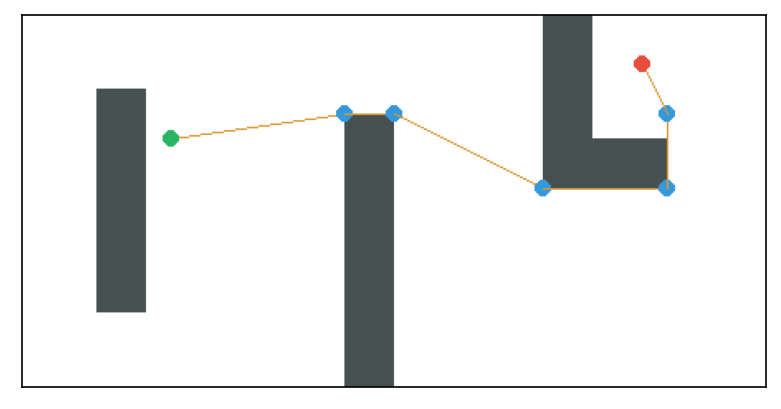

CPU times: user 142 ms, sys: 138 ms, total: 280 ms
Wall time: 113 ms


In [23]:
%time res = simple_test(lazy_theta, 6, euclidian_distance, SearchTreePQSReexp, w = 1, k = 8)

task number:  6
start:  5 6
goal:  2 25
Path found! Length: 25.941549404533223. Memory_usage: 536. Number of steps: 405
[(5, 6), (4, 13), (4, 15), (7, 21), (7, 26), (5, 26), (2, 25)]


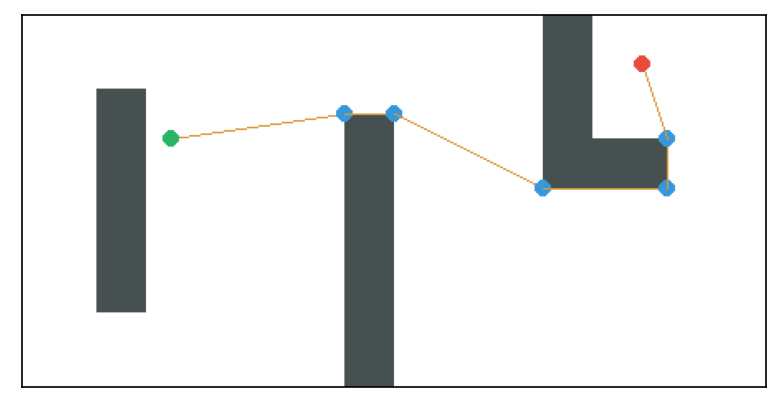

CPU times: user 168 ms, sys: 127 ms, total: 295 ms
Wall time: 113 ms


In [24]:
%time res = simple_test(lazy_theta, 6, theta_heuristic, SearchTreePQSReexp, w = 1, k = 8)